# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [21]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna
HopsworksSettings initialized!


In [22]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util_2
import os

In [23]:
today = datetime.datetime.now()

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [24]:
import json

project = hopsworks.login(engine="python")
fs = project.get_feature_store()

secrets = hopsworks.get_secrets_api()

AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value

sensors_str = secrets.get_secret("SENSORS_MADRID_JSON").value
SENSORS = json.loads(sensors_str) 

today = datetime.date.today()


2025-11-17 22:09:18,097 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 22:09:18,130 INFO: Initializing external client
2025-11-17 22:09:18,130 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 22:09:18,713 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 22:09:19,431 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271984


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [25]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=13,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 22:09:50,147 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/232664 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/99478 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93032 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/90779 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/92746 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93931 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/89199 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94858 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/34653 elapsed<00:00 remaining<?

In [26]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
#retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor(    colsample_bytree=0.9,
    gamma=0.1,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=1,
    n_estimators=200,
    reg_alpha=0.0,
    reg_lambda=1.0,
    subsample=0.9,
    objective="reg:squarederror",  
    tree_method="hist",           
    random_state=42
)

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.981061E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float'],
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name="weather_madrid_sensors",
    version=1,
)

batch_data = (
    weather_fg
    .filter(weather_fg.date >= today)
    .read()
)

feature_cols = [
    "temperature_2m_mean",
    "precipitation_sum",
    "wind_speed_10m_max",
    "wind_direction_10m_dominant",
    "cloud_cover_max",
    "relative_humidity_2m_mean",
    "dew_point_2m_max",
]

batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.38s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,cloud_cover_max,relative_humidity_2m_mean,dew_point_2m_max,city,sensor_id,country,street
0,2025-11-19 00:00:00+00:00,9.45,0.0,3.960000,90.000000,30.0,59.0,1.834259,madrid,fernandez_ladreda,spain,fernandez-ladreda
1,2025-11-18 00:00:00+00:00,10.80,0.0,1.609969,206.564987,0.0,65.0,4.481350,madrid,escuelas_aguirre,spain,escuelas-aguirre
2,2025-11-22 00:00:00+00:00,5.25,0.0,7.235910,264.289490,90.0,61.0,-1.665616,madrid,escuelas_aguirre,spain,escuelas-aguirre
3,2025-11-20 00:00:00+00:00,7.85,0.1,4.349896,335.556061,9.0,64.0,1.459012,madrid,casa_de_campo,spain,casa-de-campo
4,2025-11-23 00:00:00+00:00,11.20,0.1,15.646544,293.025513,95.0,61.0,3.953798,madrid,cuatro_caminos,spain,cuatro-caminos
5,2025-11-20 00:00:00+00:00,7.95,0.1,4.349896,335.556061,9.0,64.0,1.553982,madrid,fernandez_ladreda,spain,fernandez-ladreda
6,2025-11-23 00:00:00+00:00,11.85,0.1,15.646544,293.025513,95.0,61.0,4.567230,madrid,mendez_alvaro,spain,mendez-alvaro
7,2025-11-23 00:00:00+00:00,10.90,0.1,15.646544,293.025513,95.0,61.0,3.670645,madrid,plaza_castilla,spain,plaza-de-castilla
8,2025-11-18 00:00:00+00:00,11.20,0.0,1.609969,206.564987,0.0,65.0,4.861669,madrid,fernandez_ladreda,spain,fernandez-ladreda
9,2025-11-18 00:00:00+00:00,11.10,0.0,1.609969,206.564987,0.0,65.0,4.766593,madrid,casa_de_campo,spain,casa-de-campo


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
air_quality_fg = fs.get_external_feature_group(name='air_quality_madrid', version=1)
history = air_quality_fg.read()

# Normalize
history["date"] = pd.to_datetime(history["date"], utc=True).dt.tz_convert(None)

# Rename lag columns to match model
history = history.rename(columns={
    "pm25_lag_1": "pm25_lag1",
    "pm25_lag_2": "pm25_lag2",
    "pm25_lag_3": "pm25_lag3",
    "pm25_rolling_mean_3": "pm25_roll3"
})

# Rename weather forecast columns to match model
rename_weather = {
    "temperature_2m_mean":       "weather_madrid_sensors_temperature_2m_mean",
    "precipitation_sum":         "weather_madrid_sensors_precipitation_sum",
    "wind_speed_10m_max":        "weather_madrid_sensors_wind_speed_10m_max",
    "wind_direction_10m_dominant": "weather_madrid_sensors_wind_direction_10m_dominant",
    "cloud_cover_max":           "weather_madrid_sensors_cloud_cover_max",
    "relative_humidity_2m_mean": "weather_madrid_sensors_relative_humidity_2m_mean",
    "dew_point_2m_max":          "weather_madrid_sensors_dew_point_2m_max"
}

batch_fixed = batch_data.rename(columns=rename_weather)

# Normalize 
batch_fixed["date"] = pd.to_datetime(batch_fixed["date"], utc=True).dt.tz_convert(None)


sensors = history[['country','city','street']].drop_duplicates()

all_predictions = []

for idx, sensor in sensors.iterrows():
    country_s = sensor['country']
    city_s    = sensor['city']
    street_s  = sensor['street']

    print(f"🔮 Prediciendo para sensor: {country_s} / {city_s} / {street_s}")

    # 1) Historical data SOLO de ese sensor
    df_hist = history[
        (history["country"] == country_s) &
        (history["city"] == city_s) &
        (history["street"] == street_s)
    ].sort_values("date")

    last3 = df_hist.tail(3).copy()

    # 2) Forecast weather 1 sensor
    future = batch_fixed[
        (batch_fixed["country"] == country_s) &
        (batch_fixed["city"]    == city_s) &
        (batch_fixed["street"]  == street_s)
    ].copy()

    # Add empty pm25 column to be filled with predictions
    future["pm25"]   = None
    future["country"] = country_s
    future["city"]    = city_s
    future["street"]  = street_s

    # 3) Window 
    window = pd.concat([last3, future], ignore_index=True)
    window["date"] = pd.to_datetime(window["date"], utc=True).dt.tz_convert(None)

    preds = []
    n_hist = len(last3)

    # 4) Loop 
    for i in range(len(future)):
        # Recalcular lags y rolling sobre toda la ventana
        window = util_2.add_lags_and_rolling(window)
        window = window.sort_values("date").reset_index(drop=True)

        target_row = window.iloc[n_hist + i]

        feature_row = pd.DataFrame([{
            "weather_madrid_sensors_temperature_2m_mean":   target_row["weather_madrid_sensors_temperature_2m_mean"],
            "weather_madrid_sensors_precipitation_sum":     target_row["weather_madrid_sensors_precipitation_sum"],
            "weather_madrid_sensors_wind_speed_10m_max":    target_row["weather_madrid_sensors_wind_speed_10m_max"],
            "weather_madrid_sensors_wind_direction_10m_dominant": target_row["weather_madrid_sensors_wind_direction_10m_dominant"],
            "weather_madrid_sensors_cloud_cover_max":       target_row["weather_madrid_sensors_cloud_cover_max"],
            "weather_madrid_sensors_relative_humidity_2m_mean": target_row["weather_madrid_sensors_relative_humidity_2m_mean"],
            "weather_madrid_sensors_dew_point_2m_max":      target_row["weather_madrid_sensors_dew_point_2m_max"],
            "pm25_lag1": target_row["pm25_lag1"],
            "pm25_lag2": target_row["pm25_lag2"],
            "pm25_lag3": target_row["pm25_lag3"],
            "pm25_roll3": target_row["pm25_roll3"],
            "is_weekend": 1 if target_row["date"].weekday() >= 5 else 0
        }])

        # Order the columns as the trained model
        required_order = retrieved_xgboost_model.get_booster().feature_names
        feature_row = feature_row[required_order]

        y_hat = float(retrieved_xgboost_model.predict(feature_row)[0])
        preds.append(y_hat)

        window.loc[n_hist + i, "pm25"] = y_hat

    # 5) Save predictions in the DF of that sensor
    future["predicted_pm25"] = preds
    future["days_before_forecast_day"] = range(1, len(future) + 1)

    all_predictions.append(future)

result_df = pd.concat(all_predictions, ignore_index=True)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.04s) 
🔮 Prediciendo para sensor: spain / madrid / plaza-de-castilla
2025-11-17 22:21:36,039 WARNING: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

2025-11-17 22:21:36,044 WARNING: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

2025-11-17 22:21:36,056 WARNING: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut

In [37]:
result_df = result_df.drop(columns=["pm25"])
result_df.sort_values(by=["country", "city", "street", "date"]).head(42)

,date,weather_madrid_sensors_temperature_2m_mean,weather_madrid_sensors_precipitation_sum,weather_madrid_sensors_wind_speed_10m_max,weather_madrid_sensors_wind_direction_10m_dominant,weather_madrid_sensors_cloud_cover_max,weather_madrid_sensors_relative_humidity_2m_mean,weather_madrid_sensors_dew_point_2m_max,city,sensor_id,country,street,predicted_pm25,days_before_forecast_day
37,2025-11-18,11.10,0.0,1.609969,206.564987,0.0,65.0,4.766593,madrid,casa_de_campo,spain,casa-de-campo,28.412806,2
39,2025-11-19,9.35,0.0,3.960000,90.000000,30.0,59.0,1.740199,madrid,casa_de_campo,spain,casa-de-campo,38.016262,4
36,2025-11-20,7.85,0.1,4.349896,335.556061,9.0,64.0,1.459012,madrid,casa_de_campo,spain,casa-de-campo,26.301983,1
41,2025-11-21,5.55,0.0,5.400000,216.869980,0.0,48.0,-4.606002,madrid,casa_de_campo,spain,casa-de-campo,40.555679,6
40,2025-11-22,5.55,0.0,7.235910,264.289490,90.0,61.0,-1.382104,madrid,casa_de_campo,spain,casa-de-campo,42.024158,5
38,2025-11-23,11.55,0.1,15.646544,293.025513,95.0,61.0,4.284119,madrid,casa_de_campo,spain,casa-de-campo,34.939697,3
15,2025-11-18,10.80,0.0,1.609969,206.564987,0.0,65.0,4.481350,madrid,castellana,spain,castellana,43.756844,4
14,2025-11-19,9.05,0.0,3.960000,90.000000,30.0,59.0,1.458007,madrid,castellana,spain,castellana,41.086254,3
17,2025-11-20,7.55,0.1,4.349896,335.556061,9.0,64.0,1.174094,madrid,castellana,spain,castellana,44.921619,6
13,2025-11-21,5.25,0.0,5.400000,216.869980,0.0,48.0,-4.882004,madrid,castellana,spain,castellana,37.056313,2


In [ ]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                42 non-null     datetime64[us]
 1   weather_madrid_sensors_temperature_2m_mean          42 non-null     float32       
 2   weather_madrid_sensors_precipitation_sum            42 non-null     float32       
 3   weather_madrid_sensors_wind_speed_10m_max           42 non-null     float32       
 4   weather_madrid_sensors_wind_direction_10m_dominant  42 non-null     float32       
 5   weather_madrid_sensors_cloud_cover_max              42 non-null     float32       
 6   weather_madrid_sensors_relative_humidity_2m_mean    42 non-null     float32       
 7   weather_madrid_sensors_dew_point_2m_max             42 non-null     float32       
 8   city        

In [58]:
sensors_json = secrets.get_secret("SENSORS_MADRID_JSON").value
SENSORS = json.loads(sensors_json)
sensors_df = pd.DataFrame(SENSORS)
result_df = result_df.merge(
    sensors_df[["sensor_id", "latitude", "longitude"]],
    on="sensor_id",
    how="left"
)


In [59]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 16 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                42 non-null     datetime64[us]
 1   weather_madrid_sensors_temperature_2m_mean          42 non-null     float32       
 2   weather_madrid_sensors_precipitation_sum            42 non-null     float32       
 3   weather_madrid_sensors_wind_speed_10m_max           42 non-null     float32       
 4   weather_madrid_sensors_wind_direction_10m_dominant  42 non-null     float32       
 5   weather_madrid_sensors_cloud_cover_max              42 non-null     float32       
 6   weather_madrid_sensors_relative_humidity_2m_mean    42 non-null     float32       
 7   weather_madrid_sensors_dew_point_2m_max             42 non-null     float32       
 8   city        

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

Generando gráfica para plaza-de-castilla → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_plaza-de-castilla.png


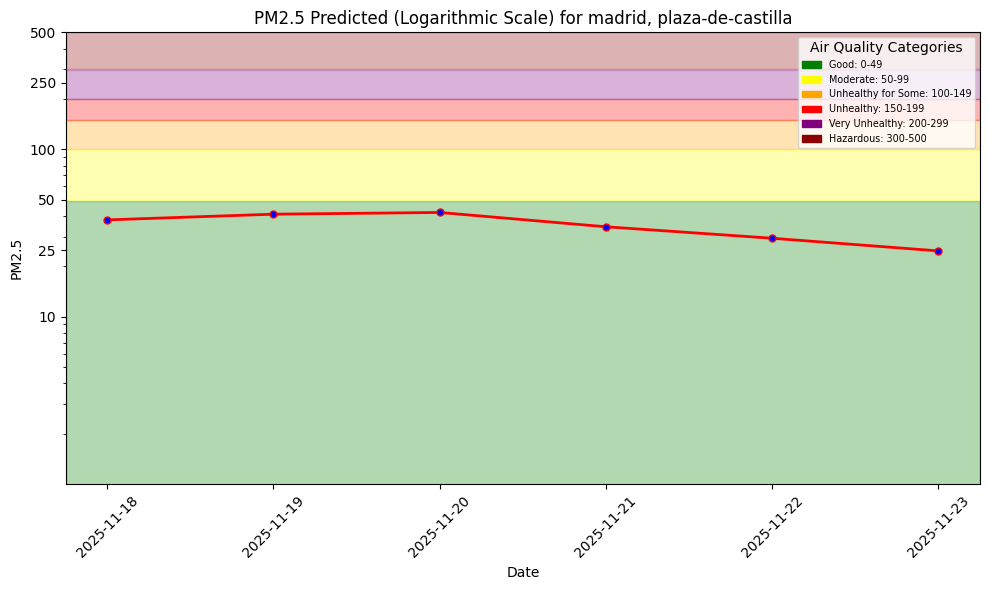

Generando gráfica para fernandez-ladreda → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_fernandez-ladreda.png


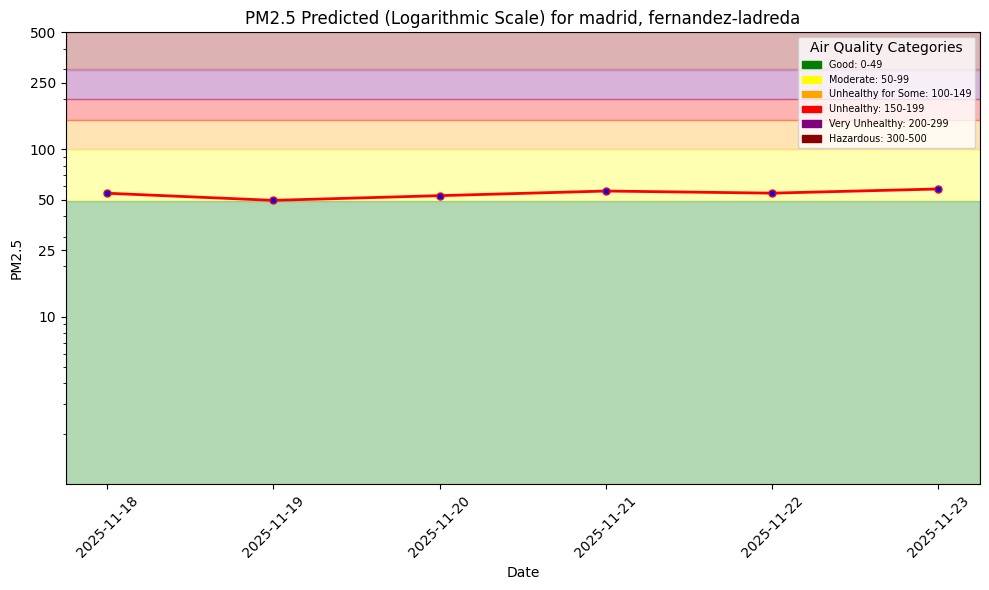

Generando gráfica para castellana → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_castellana.png


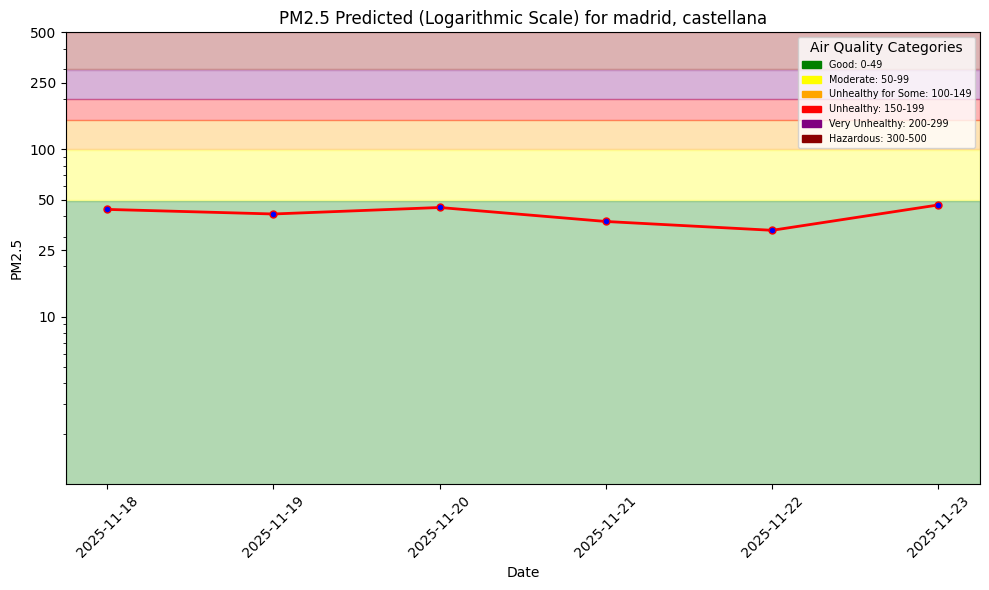

Generando gráfica para mendez-alvaro → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_mendez-alvaro.png


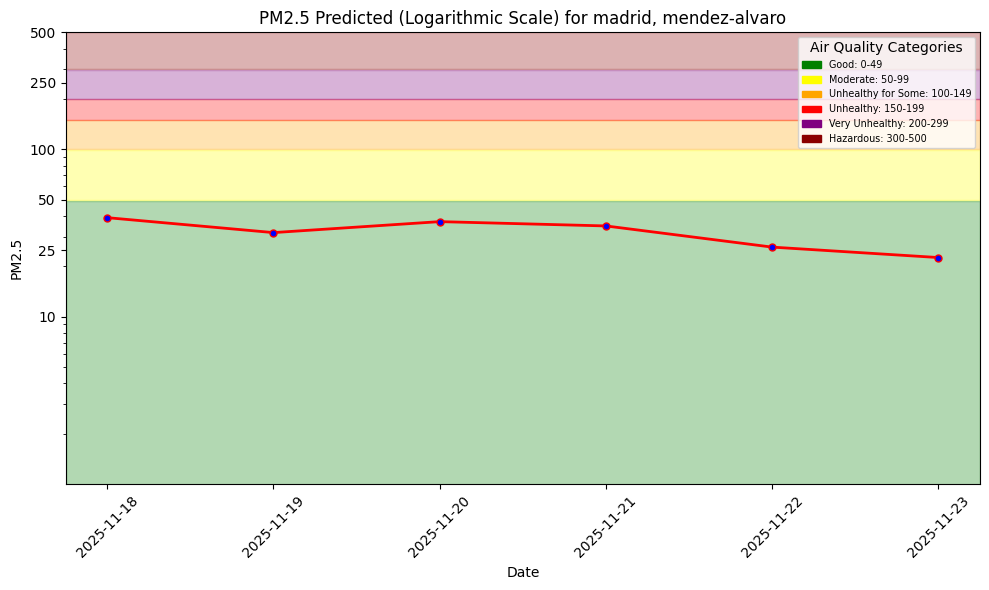

Generando gráfica para cuatro-caminos → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_cuatro-caminos.png


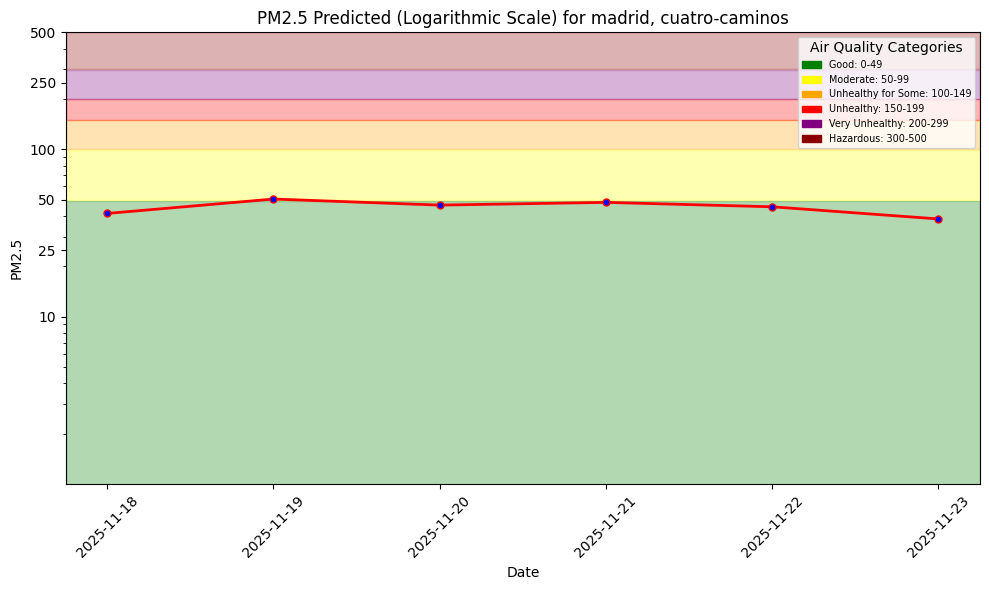

Generando gráfica para escuelas-aguirre → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_escuelas-aguirre.png


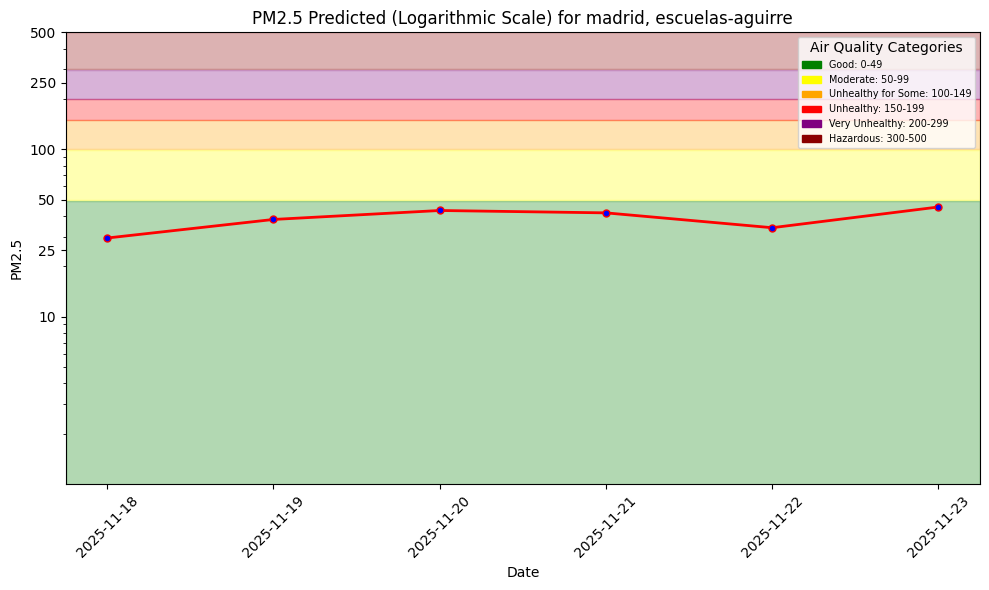

Generando gráfica para casa-de-campo → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_casa-de-campo.png


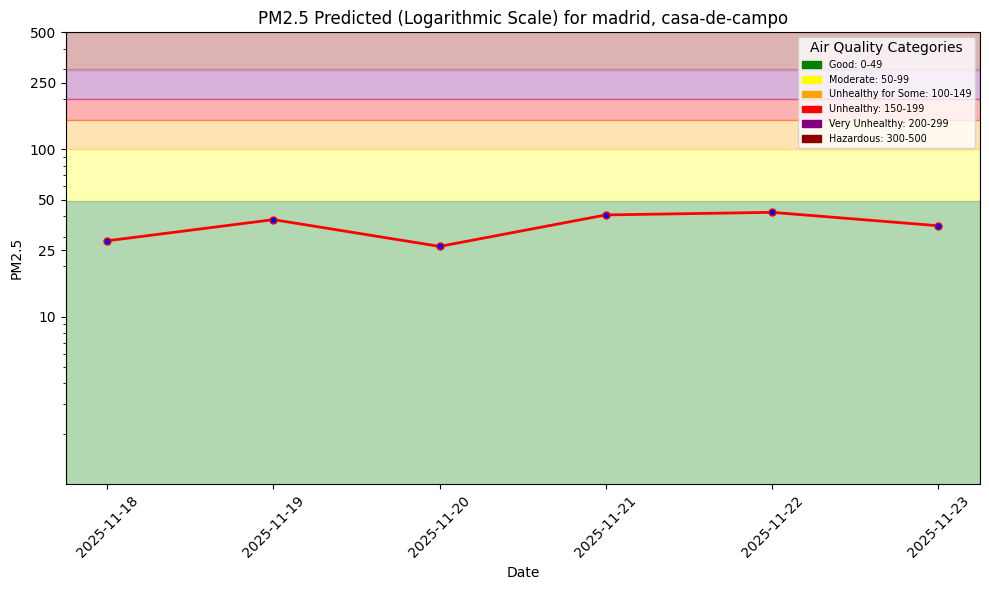

In [ ]:
# Filepath to save images
img_dir = f"{root_dir}/docs/air-quality/assets/img"
os.makedirs(img_dir, exist_ok=True)

for sensor_id in result_df['sensor_id'].unique():
    df_sensor = result_df[result_df['sensor_id'] == sensor_id].copy()
    df_sensor = df_sensor.sort_values('date')

    street_name = df_sensor['street'].iloc[0]
    city = df_sensor['city'].iloc[0]

    pred_file_path = os.path.join(
        img_dir,
        f"pm25_forecast_{street_name}.png" 
    )

    print(f"Generando gráfica para {street_name} → {pred_file_path}")

    plt = util_2.plot_air_quality_forecast(
        city,
        street_name,
        df_sensor,
        pred_file_path
    )
    plt.show()


In [44]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [45]:
monitor_fg.insert(result_df, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1271984/fs/1258583/fg/1730967


Uploading Dataframe: 100.00% |██████████| Rows 42/42 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271984/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-17 22:30:15,807 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 22:30:18,975 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 22:32:13,187 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 22:32:13,340 INFO: Waiting for log aggregation to finish.
2025-11-17 22:32:21,912 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [46]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.94s) 


,date,weather_madrid_sensors_temperature_2m_mean,weather_madrid_sensors_precipitation_sum,weather_madrid_sensors_wind_speed_10m_max,weather_madrid_sensors_wind_direction_10m_dominant,weather_madrid_sensors_cloud_cover_max,weather_madrid_sensors_relative_humidity_2m_mean,weather_madrid_sensors_dew_point_2m_max,city,sensor_id,country,street,predicted_pm25,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,10.80,0.0,1.609969,206.564987,0.0,65.0,4.481350,madrid,escuelas_aguirre,spain,escuelas-aguirre,29.520826,1
1,2025-11-19 00:00:00+00:00,9.45,0.0,3.960000,90.000000,30.0,59.0,1.834259,madrid,fernandez_ladreda,spain,fernandez-ladreda,49.549103,1
2,2025-11-23 00:00:00+00:00,11.20,0.1,15.646544,293.025513,95.0,61.0,3.953798,madrid,cuatro_caminos,spain,cuatro-caminos,38.374607,1
3,2025-11-22 00:00:00+00:00,5.25,0.0,7.235910,264.289490,90.0,61.0,-1.665616,madrid,castellana,spain,castellana,32.823265,1
4,2025-11-23 00:00:00+00:00,11.85,0.1,15.646544,293.025513,95.0,61.0,4.567230,madrid,mendez_alvaro,spain,mendez-alvaro,22.563953,1
5,2025-11-23 00:00:00+00:00,10.90,0.1,15.646544,293.025513,95.0,61.0,3.670645,madrid,plaza_castilla,spain,plaza-de-castilla,24.725298,1
6,2025-11-20 00:00:00+00:00,7.85,0.1,4.349896,335.556061,9.0,64.0,1.459012,madrid,casa_de_campo,spain,casa-de-campo,26.301983,1


In [66]:
air_quality_fg = fs.get_feature_group(name='air_quality_madrid', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.66s) 


,date,pm25,sensor_id,city,country,street,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,is_weekend
0,2015-08-09 00:00:00+00:00,28.0,plaza_castilla,madrid,spain,plaza-de-castilla,70.0,42.0,43.0,46.666667,1
1,2020-06-27 00:00:00+00:00,28.0,fernandez_ladreda,madrid,spain,fernandez-ladreda,34.0,58.0,37.0,40.000000,1
2,2016-11-26 00:00:00+00:00,21.0,castellana,madrid,spain,castellana,29.0,32.0,16.0,27.333333,1
3,2024-04-15 00:00:00+00:00,56.0,fernandez_ladreda,madrid,spain,fernandez-ladreda,50.0,46.0,35.0,50.666667,0
4,2021-01-29 00:00:00+00:00,41.0,mendez_alvaro,madrid,spain,mendez-alvaro,41.0,55.0,45.0,45.666667,0
...,...,...,...,...,...,...,...,...,...,...,...
27773,2025-11-17 00:00:00+00:00,17.0,casa_de_campo,madrid,spain,casa-de-campo,17.0,25.0,13.0,19.666667,0
27774,2025-11-17 00:00:00+00:00,17.0,mendez_alvaro,madrid,spain,mendez-alvaro,17.0,12.0,15.0,15.333333,0
27775,2025-11-17 00:00:00+00:00,59.0,fernandez_ladreda,madrid,spain,fernandez-ladreda,59.0,23.0,33.0,47.000000,0
27776,2025-11-17 00:00:00+00:00,34.0,castellana,madrid,spain,castellana,34.0,17.0,29.0,28.333333,0


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# ===================== 0. Paths & Setup =====================

try:
    _ = root_dir
except NameError:
    root_dir = os.getcwd() 

try:
    _ = result_df
except NameError:
    # Create un dummy result_df
    data = {
        'date': pd.to_datetime(['2023-11-18', '2023-11-18', '2023-11-19', '2023-11-19', '2023-11-20', '2023-11-20', '2023-11-21', '2023-11-21', '2023-11-22', '2023-11-22', '2023-11-23', '2023-11-23']),
        'city': ['madrid'] * 12,
        'street': ['Gran Via', 'Paseo Castellana', 'Alcala', 'Fuencarral'] * 3,
        'sensor_id': [f'S{i}' for i in range(1, 13)],
        'latitude': [40.420, 40.460, 40.425, 40.435, 40.410, 40.450, 40.430, 40.440, 40.400, 40.470, 40.415, 40.455],
        'longitude': [-3.703, -3.680, -3.695, -3.700, -3.710, -3.670, -3.690, -3.685, -3.720, -3.660, -3.705, -3.675],
        'predicted_pm25': [25, 60, 35, 80, 45, 120, 55, 90, 70, 150, 85, 110] * 1
    }
    data['date'] = pd.to_datetime(data['date'])
    forecast_dates = pd.date_range(start='2023-11-18', periods=6).tolist()
    
    expanded_data = []
    for i, date in enumerate(forecast_dates):
        for j in range(4):
            sensor_lat = 40.4 + (j * 0.01) + (i * 0.005) 
            sensor_lon = -3.7 + (j * 0.005) + (i * 0.003)
            pm25 = 20 + (j * 10) + (i * 5)
            expanded_data.append({
                'date': date,
                'city': 'madrid',
                'street': f'Street {j+1}',
                'sensor_id': f'S{j+1}_{date.strftime("%Y%m%d")}',
                'latitude': sensor_lat,
                'longitude': sensor_lon,
                'predicted_pm25': pm25
            })
    result_df = pd.DataFrame(expanded_data)


docs_dir = f"{root_dir}/docs"
os.makedirs(docs_dir, exist_ok=True)
output_path = f"{docs_dir}/index.html"

# ===================== 1. Data Preparation =====================
df = result_df.copy()
df = df[df["city"].str.lower() == "madrid"].copy()
df["date"] = pd.to_datetime(df["date"]).dt.date

city_daily = (
    df.groupby("date", as_index=False)["predicted_pm25"]
      .mean()
      .rename(columns={"predicted_pm25": "predicted_pm25_citymean"})
      .sort_values("date")
      .reset_index(drop=True)
)

if city_daily.empty:
    raise ValueError("No Madrid rows found")

today_row = city_daily.iloc[0]
tomorrow_row = city_daily.iloc[1] if len(city_daily) > 1 else None
mean_val = city_daily["predicted_pm25_citymean"].mean()
max_row = city_daily.loc[city_daily["predicted_pm25_citymean"].idxmax()]


center_lat = float(df["latitude"].mean())
center_lon = float(df["longitude"].mean())
unique_dates = sorted(df["date"].unique())
city_mean_by_date = city_daily.set_index("date")["predicted_pm25_citymean"].to_dict()

# AQI Colorscale (same scale for all)
AQI_COLORSCALE = [
    [0.0, "#00e400"], [50/600, "#00e400"],
    [50/600, "#ffff00"], [100/600, "#ffff00"],
    [100/600, "#ff7e00"], [150/600, "#ff7e00"],
    [150/600, "#ff0000"], [200/600, "#ff0000"],
    [200/600, "#99004c"], [300/600, "#99004c"],
    [300/600, "#7e0023"], [1.0, "#7e0023"],
]

# ===================== 2. Plotly Map Logic =====================

def make_traces(day_df):
    day = day_df["date"].iloc[0] if not day_df.empty else unique_dates[0]
    city_mean_val = city_mean_by_date.get(day, float("nan"))
    city_mean_val = float(city_mean_val) if pd.notna(city_mean_val) else float("nan")

    # Sensor points trace
    sensors = go.Scattermap(
        lat=day_df["latitude"],
        lon=day_df["longitude"],
        mode="markers",
        marker=dict(
            size=14,
            color=day_df["predicted_pm25"],
            colorscale=AQI_COLORSCALE,
            cmin=0, cmax=600,
            opacity=0.9,
            showscale=False,
        ),
        text=[f"<b>{r['street']}</b><br>Sensor: {r['sensor_id']}<br>PM2.5: {r['predicted_pm25']:.1f} µg/m³" for _, r in day_df.iterrows()],
        hoverinfo="text",
        name="Sensors"
    )

    # Trace
    madrid_marker = go.Scattermap(
        lat=[center_lat],
        lon=[center_lon],
        mode="markers",
        marker=dict(
            size=26, 
            color=[city_mean_val],
            colorscale=AQI_COLORSCALE,
            cmin=0, cmax=600,
            showscale=False,
            symbol='circle', 
        ),
        text=[f"<b>Madrid (City Mean)</b><br>PM2.5: {city_mean_val:.1f} µg/m³"],
        hoverinfo="text",
        name="Madrid City Mean",
        showlegend=False,
    )

    return [sensors, madrid_marker]

fig_map = go.Figure()
initial_df = df[df["date"] == unique_dates[0]]
for t in make_traces(initial_df):
    fig_map.add_trace(t)

frames = []
for d in unique_dates:
    day_df = df[df["date"] == d]
    frames.append(go.Frame(data=make_traces(day_df), name=str(d)))
fig_map.frames = frames

slider_steps = []
for i, d in enumerate(unique_dates):
    label_fmt = pd.to_datetime(d).strftime("%d %b")
    slider_steps.append(dict(
        label=label_fmt,
        method="animate",
        args=[[str(d)], {"mode": "immediate", "frame": {"duration": 0, "redraw": True}}]
    ))

fig_map.update_layout(
    map=dict(
        style="carto-positron",
        center=dict(lat=center_lat, lon=center_lon),
        zoom=10.5,
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    height=600, 
    showlegend=False,
    sliders=[dict(
        active=0,
        steps=slider_steps,
        currentvalue={"prefix": "Forecast: ", "font": {"size": 14, "family": "Karla"}},
        pad={"t": 30, "b": 10}, 
        len=0.9, x=0.05, y=0.0, 
        bgcolor="white",
        bordercolor="#ddd",
        borderwidth=1,
        font=dict(size=12, family="Karla", color="#666")
    )],
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        x=0.05, y=0.10, 
        xanchor="left",
        yanchor="top",
        buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration": 800}}])]
    )]
)

map_html = pio.to_html(fig_map, full_html=False, include_plotlyjs="cdn", config={'displayModeBar': False})

# ===================== 3. HTML & CSS Styling (The Worldpay Look) =====================

icon_calendar = """<svg width="24" height="24" viewBox="0 0 24 24" fill="none" stroke="#333" stroke-width="2" stroke-linecap="round" stroke-linejoin="round"><rect x="3" y="4" width="18" height="18" rx="2" ry="2"></rect><line x1="16" y1="2" x2="16" y2="6"></line><line x1="8" y1="2" x2="8" y2="6"></line><line x1="3" y1="10" x2="21" y2="10"></line></svg>"""
icon_chart = """<svg width="24" height="24" viewBox="0 0 24 24" fill="none" stroke="#333" stroke-width="2" stroke-linecap="round" stroke-linejoin="round"><line x1="18" y1="20" x2="18" y2="10"></line><line x1="12" y1="20" x2="12" y2="4"></line><line x1="6" y1="20" x2="6" y2="14"></line></svg>"""
icon_wind = """<svg width="24" height="24" viewBox="0 0 24 24" fill="none" stroke="#333" stroke-width="2" stroke-linecap="round" stroke-linejoin="round"><path d="M9.59 4.59A2 2 0 1 1 11 8H2m10.59 11.41A2 2 0 1 0 14 16H2m15.73-8.27A2.5 2.5 0 1 1 19.5 12H2"></path></svg>"""
icon_alert = """<svg width="24" height="24" viewBox="0 0 24 24" fill="none" stroke="#333" stroke-width="2" stroke-linecap="round" stroke-linejoin="round"><circle cx="12" cy="12" r="10"></circle><line x1="12" y1="8" x2="12" y2="12"></line><line x1="12" y1="16" x2="12.01" y2="16"></line></svg>"""

html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Madrid Air Quality Insights</title>
    <link rel="preconnect" href="https://fonts.googleapis.com">
    <link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
    <link href="https://fonts.googleapis.com/css2?family=DM+Serif+Display&family=Karla:wght@400;500;700&display=swap" rel="stylesheet">
    
    <style>
        :root {{
            --bg-color: #f8f9fa;
            --text-dark: #1a1a1a;
            --text-light: #666;
            --accent: #0056b3;
            --border: #e0e0e0;
        }}

        body {{
            margin: 0;
            font-family: 'Karla', sans-serif;
            background-color: var(--bg-color);
            color: var(--text-dark);
            background-image: radial-gradient(#cfd8dc 1px, transparent 1px);
            background-size: 20px 20px;
            min-height: 100vh;
            display: flex;
            align-items: center;
            justify-content: center;
        }}

        .dashboard-container {{
            width: 95%;
            max-width: 1400px;
            background: #fff;
            border-radius: 4px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.08);
            display: grid;
            grid-template-columns: 300px 1fr 320px;
            overflow: hidden;
            min-height: 700px; /* Ajustado para el nuevo tamaño del mapa */
        }}

        /* === Columna Izquierda: Contexto === */
        .col-left {{
            padding: 40px;
            display: flex;
            flex-direction: column;
            justify-content: flex-start;
            border-right: 1px solid var(--border);
        }}
        
        .meta-tag {{
            text-transform: uppercase;
            font-size: 11px;
            letter-spacing: 1px;
            color: #888;
            margin-bottom: 10px;
            font-weight: 700;
        }}

        h1 {{
            font-family: 'DM Serif Display', serif;
            font-size: 36px;
            line-height: 1.1;
            margin: 0 0 20px 0;
            color: #000;
        }}

        .description {{
            font-size: 15px;
            line-height: 1.6;
            color: var(--text-light);
            margin-bottom: 30px;
        }}

        .legend-box {{
            margin-top: auto;
            background: #f9f9f9;
            padding: 15px;
            border-radius: 4px;
        }}
        .legend-title {{ font-weight: bold; font-size: 12px; margin-bottom: 8px; }}
        .gradient-bar {{
            height: 8px;
            width: 100%;
            /* Esta es la escala de colores que usaste, ajustada a la sintaxis CSS */
            background: linear-gradient(to right, #00e400 0%, #00e400 8.33%, #ffff00 8.33%, #ffff00 16.66%, #ff7e00 16.66%, #ff7e00 25%, #ff0000 25%, #ff0000 33.33%, #99004c 33.33%, #99004c 50%, #7e0023 50%, #7e0023 100%);
            border-radius: 4px;
        }}
        .legend-labels {{
            display: flex;
            justify-content: space-between;
            font-size: 10px;
            margin-top: 4px;
            color: #666;
        }}

        /* === Columna Central: Mapa === */
        .col-center {{
            position: relative;
            background: #fff;
        }}
        
        /* Asegura que el contenedor de Plotly ocupe el 100% */
        .col-center > div {{
            height: 100% !important;
            width: 100% !important;
        }}
        .js-plotly-plot {{
            height: 100% !important;
            width: 100% !important;
        }}
        .plotly .main-svg {{
            background: transparent !important;
        }}

        /* === Columna Derecha: Estadísticas (Estilo Worldpay) === */
        .col-right {{
            padding: 40px;
            background: #fff;
            border-left: 1px solid var(--border);
            display: flex;
            flex-direction: column;
            justify-content: center;
        }}

        .stat-header {{
            font-family: 'DM Serif Display', serif;
            font-size: 22px;
            margin-bottom: 30px;
            color: #000;
        }}

        .stat-item {{
            display: flex;
            align-items: flex-start;
            padding: 20px 0;
            border-bottom: 1px solid var(--border);
        }}

        .stat-item:last-child {{ border-bottom: none; }}

        .stat-icon {{
            width: 40px;
            height: 40px;
            margin-right: 15px;
            display: flex;
            align-items: center;
            justify-content: center;
            color: #333;
        }}
        
        .stat-content {{
            flex: 1;
        }}

        .stat-label {{
            font-size: 12px;
            text-transform: uppercase;
            letter-spacing: 0.5px;
            color: #888;
            margin: 0 0 4px 0;
            font-weight: 700;
        }}

        .stat-value {{
            font-family: 'DM Serif Display', serif;
            font-size: 28px;
            color: #000;
            margin: 0;
            line-height: 1;
        }}

        .stat-sub {{
            font-size: 12px;
            color: var(--text-light);
            margin-top: 4px;
        }}

        /* Responsive */
        @media (max-width: 1000px) {{
            .dashboard-container {{
                grid-template-columns: 1fr;
                height: auto;
                padding-bottom: 20px;
            }}
            .col-left, .col-right {{
                padding: 20px;
                border: none;
            }}
            .col-right {{
                background: #fafafa;
            }}
        }}
    </style>
</head>
<body>

<div class="dashboard-container">
    
    <div class="col-left">
        <div class="meta-tag">Data Intelligence · Madrid</div>
        <h1>How is the air quality evolving?</h1>
        <p class="description">
            Use the controls to visualize the predicted PM2.5 concentration across Madrid over the coming days.
            The map highlights sensor readings, providing a granular view of pollution hotspots relative to the city center.
        </p>
        
        <div class="legend-box">
            <div class="legend-title">PM2.5 Scale (µg/m³)</div>
            <div class="gradient-bar"></div>
            <div class="legend-labels">
                <span>0</span>
                <span>Good</span>
                <span>Hazardous</span>
                <span>600+</span>
            </div>
        </div>
    </div>

    <div class="col-center">
        {map_html}
    </div>

    <div class="col-right">
        <div class="stat-header">Madrid Overview</div>

        <div class="stat-item">
            <div class="stat-icon">{icon_calendar}</div>
            <div class="stat-content">
                <p class="stat-label">Today's Mean</p>
                <h2 class="stat-value">{today_row.predicted_pm25_citymean:.1f}</h2>
                <p class="stat-sub">µg/m³ ({today_row["date"]})</p>
            </div>
        </div>

        {f'''
        <div class="stat-item">
            <div class="stat-icon">{icon_chart}</div>
            <div class="stat-content">
                <p class="stat-label">Tomorrow's Forecast</p>
                <h2 class="stat-value">{tomorrow_row.predicted_pm25_citymean:.1f}</h2>
                <p class="stat-sub">µg/m³ ({tomorrow_row["date"]})</p>
            </div>
        </div>
        ''' if tomorrow_row is not None else ""}

        <div class="stat-item">
            <div class="stat-icon">{icon_wind}</div>
            <div class="stat-content">
                <p class="stat-label">Period Average</p>
                <h2 class="stat-value">{mean_val:.1f}</h2>
                <p class="stat-sub">Average across all days</p>
            </div>
        </div>

        <div class="stat-item">
            <div class="stat-icon">{icon_alert}</div>
            <div class="stat-content">
                <p class="stat-label">Peak Day</p>
                <h2 class="stat-value">{max_row.predicted_pm25_citymean:.1f}</h2>
                <p class="stat-sub">Highest pollution on {max_row["date"]}</p>
            </div>
        </div>

    </div>

</div>

</body>
</html>
"""

with open(output_path, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"Dashboard estilo Worldpay generado en: {output_path}")

Dashboard estilo Worldpay generado en: /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/index.html
